In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [4]:


@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    


In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [6]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]

    f = (R0 * x-1) * (y<1/kappa) + (y>=1/kappa)
    dydt =  f * y
    dxdt = - R0 *x * y*(y<1/kappa) -  (R0*x-1)*(x<=1/R0)
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, kappa): 
    def model(y,t):
        S = y[0]
        I = y[1]
        
        x = S/N
        y= I/N

        a = 1/(R0*S/N)*(kappa/N*I >1) + (kappa/N*I <=1)
        foi = (R0*a*x) *(x>1/R0) +  (R0*x)*(x<=1/R0)
        f= foi - 1
        dIdt = N*f*y 
        dSdt = - N*foi*y
        return [dSdt,dIdt]
    return model

def vacc_model(X, t, R0, kappa,v,t0):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0*(1-kappa * y) *x * y - v * (x-1/2)*(t>t0)
    dydt =  R0*(1-kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def vacc_model_w_params(R0, N, kappa,v,t0,vlim ): 
    def model(y,t):
        S = y[0]
        I = y[1]
        V = y[2]

        x = S/N
        y= I/N

        a = 1/(R0*S/N)*(kappa/N*I >1) + (kappa/N*I <=1)

        foi = ((R0*a) *(x>1/R0) +  (R0)*(x<=1/R0) )*x
        f= foi - 1 
        
        R0_eff = R0*(1-kappa*I/(N))
        dVdt = v*np.heaviside(t-t0,1)*(1-V/(vlim*N))
        dSdt = - N*foi*y - dVdt
        dIdt =  N*f*y 
        return [dSdt,dIdt,dVdt]
    return model

In [7]:
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

def vacc_integrate_trajectory(R0,kappa,v, t0, N,I0 = 10, Nsteps = int(1e4), vlim = 1/2):
    S0 = N-I0
    y0 = [S0,I0,0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]

    solution  = odeint(vacc_model_w_params(R0,N,kappa,v,t0,vlim),y0,ts).T

    return ts, solution

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
R0= 3
kappa = 3e3

vlim = .3
dbar = 10
xi = 50
ds = np.arange(0,10*dbar,1)

t0 = 50
N = 1e8
v = N/24


# f= (R0*a*x-1) *(x>1/R0) - x*(x<=1/R0) 

a_t= lambda x,y, kappa:  1/(R0*x)*(kappa*y >1) + (kappa*y <=1)

f_d_v_func = lambda d,xi, x,y, z, zv, R0, kappa: R0*a_t(x,y,kappa)*(x + (1-np.exp(-d/xi))*(z+ zv) ) -1
f_d_func = lambda d,xi, x,y, z, R0, kappa: R0*a_t(x,y,kappa)*(x + (1-np.exp(-d/xi))*z ) -1

x_d_func = lambda d,xi, x_v0,y_v0,z_v0,R0,kappa: x_v0 + (1-np.exp(-d/xi))*z_v0
x_d_v_func = lambda d,xi, x,y,z,zv,R0,kappa: x + (1-np.exp(-d/xi))*(z+zv)


UN = 1e3
delta = dbar/xi


ts, (S,I,V) = vacc_integrate_trajectory(R0,kappa,v,t0,N, Nsteps = int(1e5),vlim=vlim)
x,y= S/N,I/N
z_v = V/N
ts_v0, (S_v0,I_v0) = integrate_trajectory(R0,kappa,N, Nsteps = int(1e5))
x_v0,y_v0= S_v0/N,I_v0/N

z= np.cumsum(y)*np.diff(ts)[0]
z_v0= np.cumsum(y_v0)*np.diff(ts_v0)[0]

rhos= np.exp(-(ds-1)/dbar).reshape(-1,1)/dbar

p_surv_v_d_t = np.zeros((len(ds),len(ts)))
p_surv_d_t = np.zeros((len(ds),len(ts)))

for i,d in enumerate(ds):
    fv_d = f_d_v_func(d,xi,x,y,z,z_v,R0,kappa)
    fv_0 = f_d_v_func(0,xi,x,y,z,z_v,R0,kappa)

    f_d = f_d_func(d,xi,x_v0,y_v0,z_v0,R0,kappa)
    piv_d = np.maximum(fv_d/(1+fv_d),0)
    pi_d = np.maximum(f_d/(1+f_d),0)

    p_surv_v_d_t[i] = piv_d
    p_surv_d_t[i] = pi_d

yp = np.max(y)
tp = ts[y>yp*.99][0]
ind_p = np.arange(len(ts))[ts>tp][0]

eps_v_d_t = UN*y*p_surv_v_d_t*rhos
eps_d_t = UN*y_v0*p_surv_d_t*rhos


eps_v_t = np.sum(eps_v_d_t,axis=0)
eps_t = np.sum(eps_d_t,axis=0)

cum_eps_v_t = np.cumsum(eps_v_t)*np.diff(ts)[0]
cum_eps_t = np.cumsum(eps_t)*np.diff(ts)[0]

cum_eps_v_t-= cum_eps_v_t[ind_p]
cum_eps_t-= cum_eps_t[ind_p]

ttilde_0 = ts[np.argmin(np.abs(cum_eps_t-1))]
minf_0 = cum_eps_t[-1]
def get_ttilde_and_minf(R0,kappa, N, v,t0, vlim, dbar, xi, UN, ax =None):
    ds = np.arange(0,10*dbar,1)
    ts, (S,I,V) = vacc_integrate_trajectory(R0,kappa,v,t0,N, Nsteps = int(5e5),vlim=vlim)
    x,y= S/N,I/N
    z_v = V/N
    z= np.cumsum(y)*np.diff(ts)[0]
    
    rhos= np.exp(-(ds-1)/dbar).reshape(-1,1)/dbar

    p_surv_v_d_t = np.zeros((len(ds),len(ts)))

    for i,d in enumerate(ds):
        fv_d = f_d_v_func(d,xi,x,y,z,z_v,R0,kappa)
        fv_0 = f_d_v_func(0,xi,x,y,z,z_v,R0,kappa)

        piv_d = np.maximum(fv_d/(1+fv_d),0)

        p_surv_v_d_t[i] = piv_d

    yp = np.max(y)
    tp = ts[y>yp*.99][0]
    ind_p = np.arange(len(ts))[ts>tp][0]

    eps_v_d_t = UN*y*p_surv_v_d_t*rhos
    eps_v_t = np.sum(eps_v_d_t,axis=0)
    cum_eps_v_t = np.cumsum(eps_v_t)*np.diff(ts)[0]
    cum_eps_v_t-= cum_eps_v_t[ind_p]
    ttilde = ts[np.argmin(np.abs(cum_eps_v_t-1))]

    if ax is not None:
        ax.plot(ts,cum_eps_v_t, label = r'$\kappa = $'+str(kappa))
    return ttilde, cum_eps_v_t[-1]


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1473165018213D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2946330036425D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2946330036425D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2419471288668D-14


In [10]:
ttilde_0

308.5194619461745

0it [00:00, ?it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1472847300363D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2945694600725D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2945694600725D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2419210370496D-14


1it [00:00,  1.03it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2450710101134D-14


2it [00:01,  1.10it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2602987371262D-14


5it [00:04,  1.22it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1796096828504D-14


7it [00:05,  1.47it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1622579264314D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3245158528627D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3245158528627D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2539204885055D-14


9it [00:06,  1.52it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1942365839797D-14


10it [00:07,  1.56it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1513502052883D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3027004105766D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3027004105766D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2452371633852D-14


11it [00:07,  1.55it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2997893258565D-14


13it [00:09,  1.64it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1772812367816D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3545624735631D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3545624735631D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2654154375076D-14


14it [00:09,  1.74it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2004812935110D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2004812935110D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2004812935110D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2004812935110D-14
 lsoda--  warning..internal t (=r1) 

15it [00:10,  1.74it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1451159614862D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2902319229724D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2902319229724D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2401332862299D-14


18it [00:11,  1.87it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2017795407254D-14


19it [00:12,  1.91it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2310280807157D-14


23it [00:14,  2.00it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1808240270569D-14


24it [00:14,  1.99it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2822066128758D-14


26it [00:15,  1.93it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3425512630767D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3425512630767D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3425512630767D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3425512630767D-14


27it [00:16,  1.85it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2998691982496D-14


28it [00:16,  1.89it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1197946829148D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1197946829148D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1197946829148D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1197946829148D-14
 lsoda--  warning..internal t (=r1) 

29it [00:17,  1.90it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1638876967365D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3277753934730D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3277753934730D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2551925320227D-14


30it [00:17,  1.93it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1554181533506D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3108363067012D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3108363067012D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2485110200020D-14


32it [00:18,  1.99it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2388819526376D-14


33it [00:19,  2.01it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7760583598417D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7760583598417D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7760583598417D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.7760583598417D-15
 lsoda--  warning..internal t (=r1) 

34it [00:19,  2.01it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2008374955738D-14


36it [00:20,  2.02it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1441543363865D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2883086727731D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2883086727731D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2393363300198D-14


38it [00:21,  2.01it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1542963827027D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3085927654054D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3085927654054D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2476125491756D-14


39it [00:22,  1.98it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2140034053618D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2140034053618D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2140034053618D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2140034053618D-14


40it [00:22,  2.01it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2952396286463D-14


41it [00:23,  2.00it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3454694461898D-14


42it [00:23,  1.99it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2669663694966D-14


43it [00:24,  1.99it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1677067343755D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3354134687510D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3354134687510D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2581487572307D-14


44it [00:24,  2.00it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1898976028849D-14


47it [00:26,  1.99it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1490148374902D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2980296749804D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2980296749804D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2433377746149D-14


48it [00:26,  1.98it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2683568544073D-14


50it [00:27,  1.80it/s]


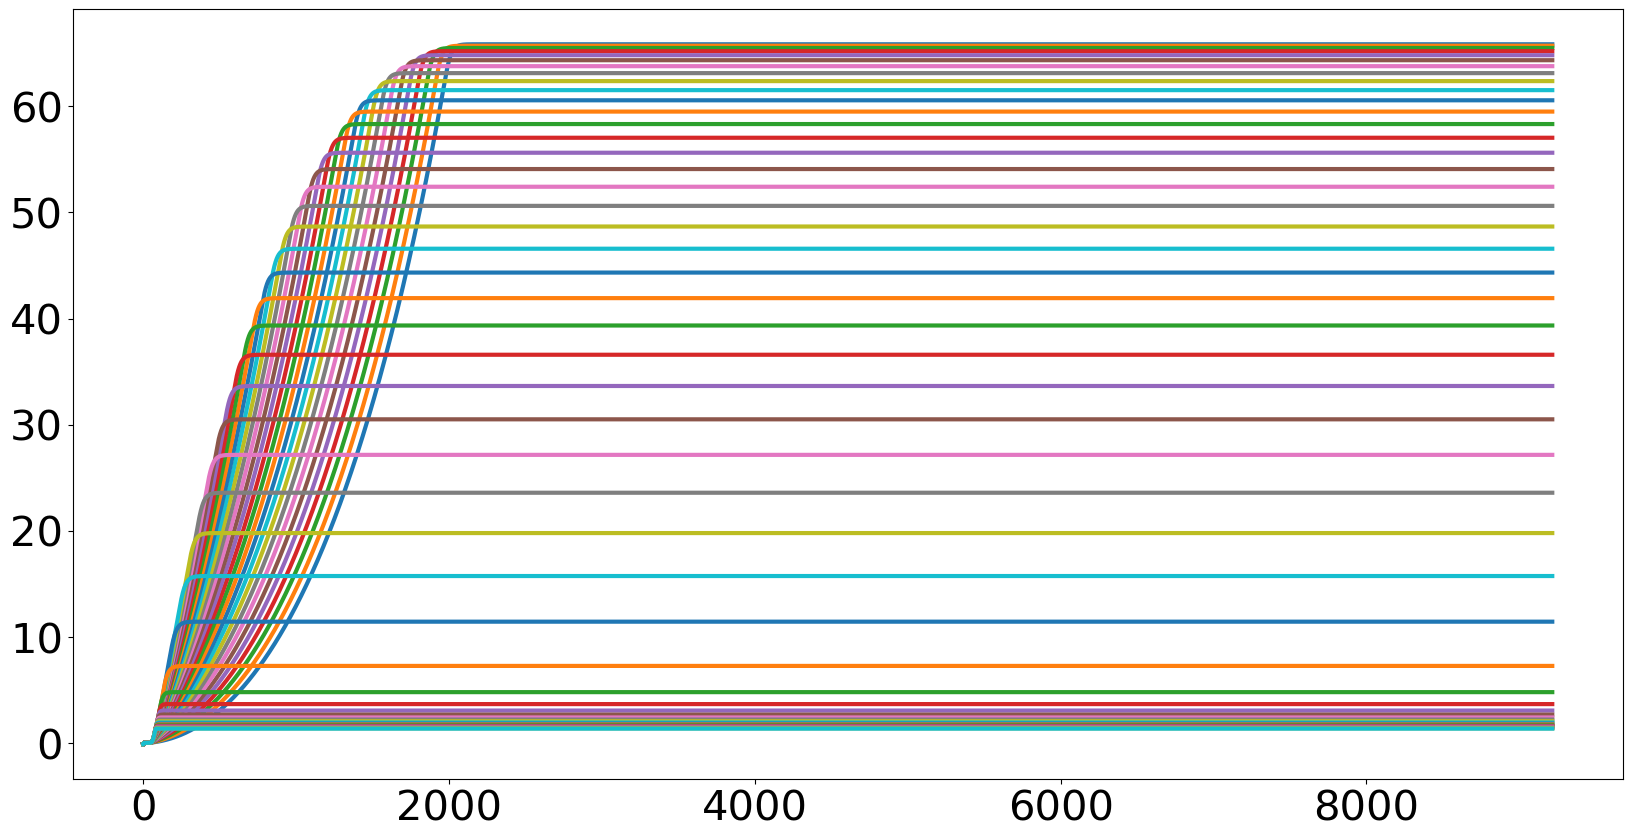

In [11]:
vlim_vals = np.linspace(0.01,.99,50)

ttilde_vals = np.zeros(len(vlim_vals))
ttilde_0_vals = np.zeros(len(vlim_vals))
minf_vals = np.zeros(len(vlim_vals))
minf_0_vals = np.zeros(len(vlim_vals))
fig,ax= plt.subplots()

for i,vlim in tqdm(enumerate(vlim_vals)):
    ttilde,  minf, = get_ttilde_and_minf(R0,kappa, N, v,t0, vlim, dbar, xi, UN, ax =ax)
    ttilde_vals[i] = ttilde
    minf_vals[i] = minf

In [12]:
ttilde_vals

array([284.20791883, 243.29347879, 211.40970345, 186.69517007,
       167.49118516, 152.4155041 , 140.41762101, 130.77876869,
       122.90918946, 116.42185482, 111.02188594, 106.48812366,
       102.67312858,  99.41103133,  96.62811221,  94.23222158,
        92.16806965,  90.38036664,  88.81382276,  87.4500081 ,
        86.25206278,  85.18312696,  84.24320063,  83.39542395,
        82.6397969 ,  81.95788957,  81.34970195,  80.77837418,
        80.28076612,  79.801588  ,  79.37769966,  78.99067117,
        78.62207261,  78.29033391,  77.97702513,  77.68214628,
        77.40569737,  77.14767837,  76.92651924,  76.68693018,
        76.48420097,  76.28147176,  76.09717248,  75.93130313,
        75.76543378,  75.59956443,  75.452125  ,  75.30468558,
        75.17567608,  75.04666659])

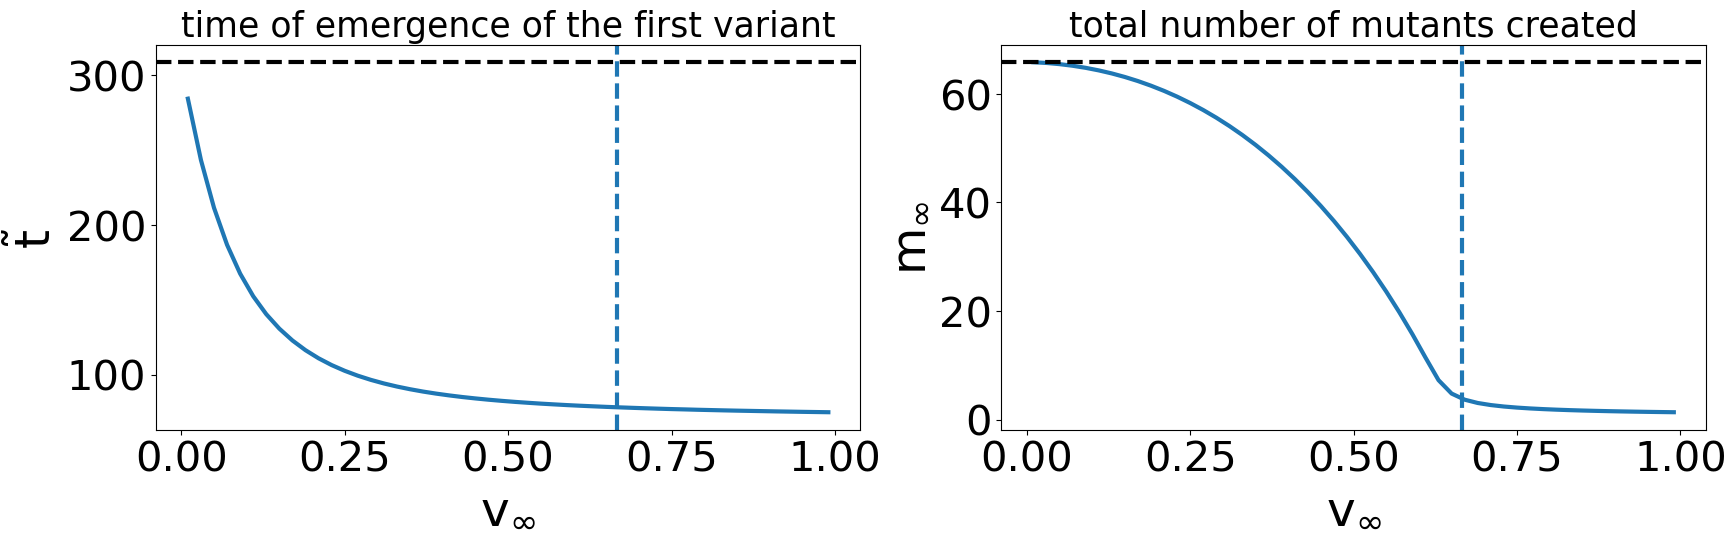

In [13]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(vlim_vals, ttilde_vals, label = r'$\tilde{t}$')
# ax[0].plot(vlim_vals, ttilde_0_vals, label = r'$\tilde{t}_0$')
ax[0].axhline(ttilde_0, color = 'k', linestyle = '--')
# ax[0].set_xscale('log')

ax[1].plot(vlim_vals, minf_vals, label = r'$\minf$')
# ax[1].plot(vlim_vals, minf_0_vals, label = r'$\minf_0$')
ax[1].axhline(minf_0, color = 'k', linestyle = '--')
# ax[1].set_xscale('log')

ax[0].set_xlabel(r'$v_{\infty}$')
ax[1].set_xlabel(r'$v_{\infty}$')

ax[0].set_ylabel(r'$\tilde{t}$')
ax[1].set_ylabel(r'$m_\infty$')

ax[0].set_title('time of emergence of the first variant',fontsize=25)
ax[1].set_title('total number of mutants created',fontsize=25)

ax[1].axvline((R0-1)/R0,ls='--')
ax[0].axvline((R0-1)/R0,ls='--')
# ax[1].set_ylabel(r'$\minf$')


In [14]:
1/delta *R0/((R0-1)**2)* np.sqrt(4*R0-3)

11.25

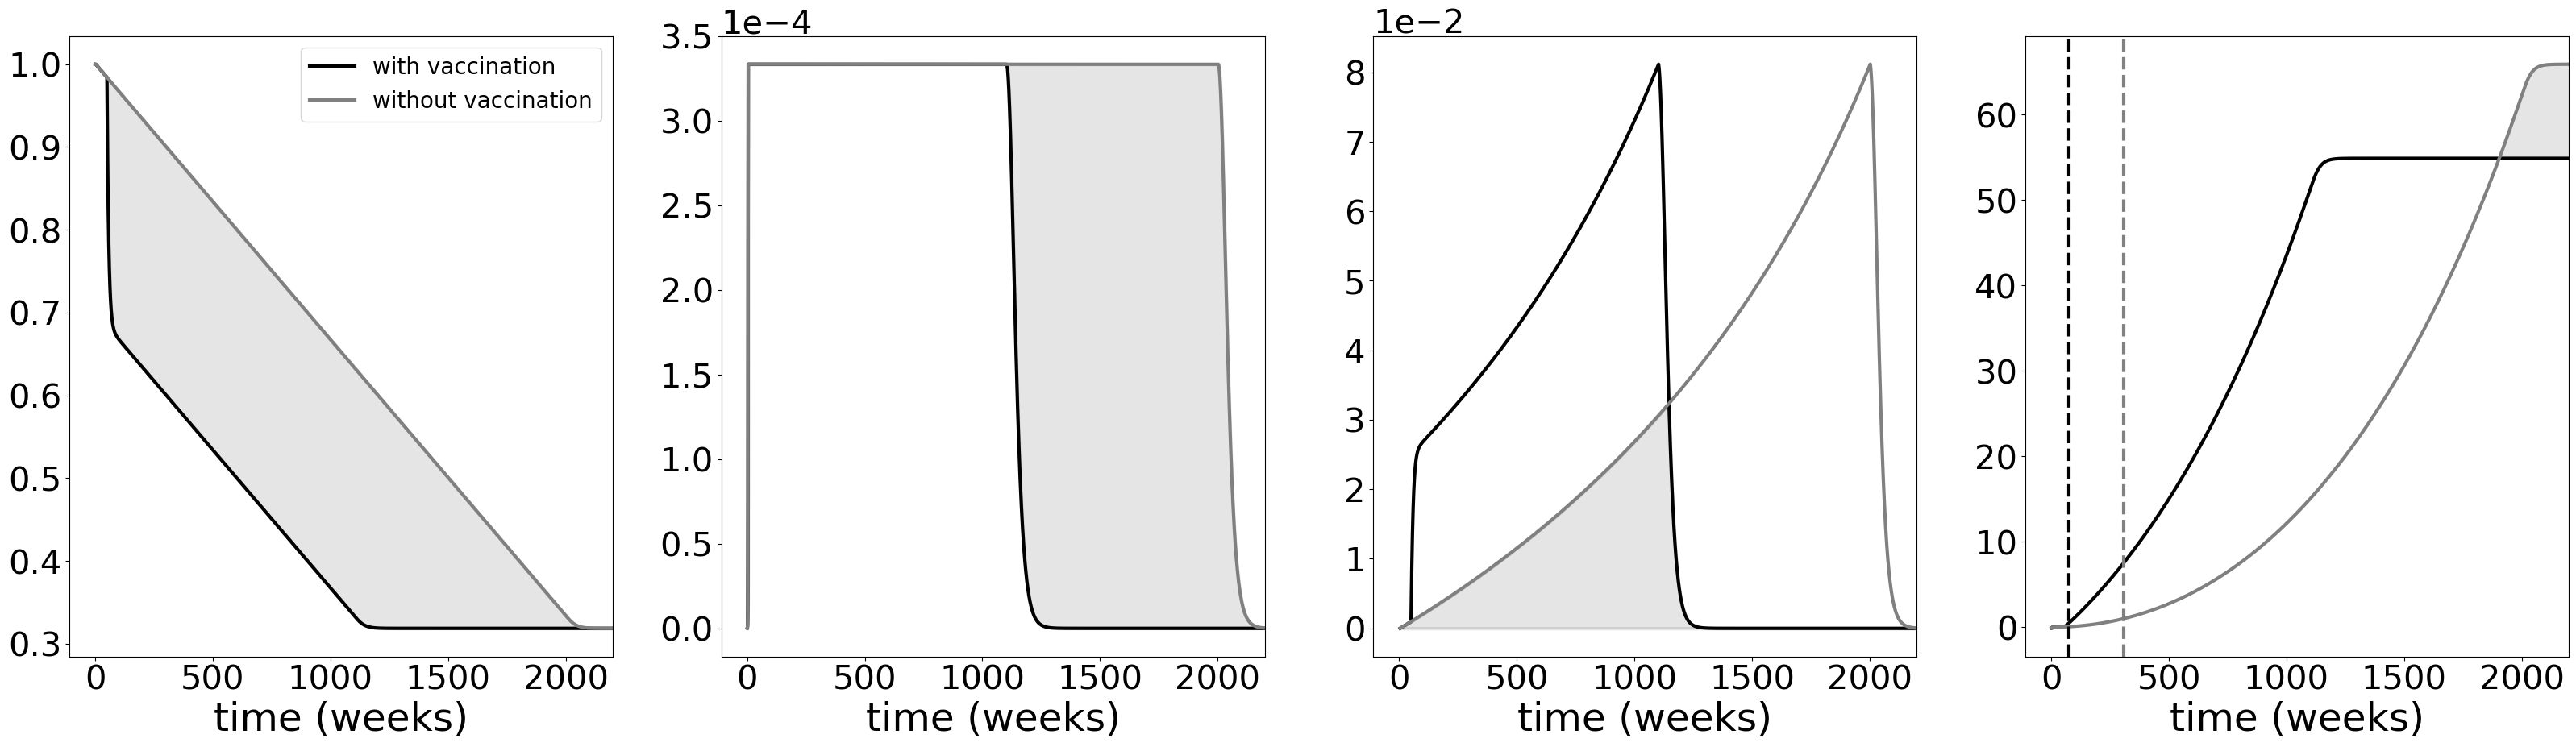

In [18]:


fig,ax= plt.subplots(1,4,figsize=(40,10))
plt.subplots_adjust(wspace=0.2)
ax[0].plot(ts,x, label = 'with vaccination', color= 'k',lw=3)
ax[0].plot(ts_v0,x_v0, label = 'without vaccination',color='grey',lw=3)

ax[0].fill_between(ts,x_v0,x, color='k',alpha=.1,lw=3)

ax[1].plot(ts,y, label = 'with vaccination', color= 'k',markevery=200,markersize=10,lw=3)
ax[1].plot(ts_v0,y_v0, label = 'without vaccination',color='grey',lw=3)
ax[1].fill_between(ts,y_v0,y, color='k',alpha=.1,lw=3)

ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

z= np.cumsum(y)*np.diff(ts)[0]
z_v0= np.cumsum(y_v0)*np.diff(ts_v0)[0]

yp = np.max(y)
tp = ts[y>yp*.99][0]

ax[2].plot(ts[ts>tp],eps_v_t[ts>tp], label = 'with vaccinations', color='k',lw=3)
ax[2].plot(ts[ts>tp],eps_t[ts>tp], label = 'without vaccinations', color='grey',lw=3)

ax[2].fill_between(ts[ts>tp],0,np.minimum(eps_v_t,eps_t)[ts>tp], color='k',alpha=.1,lw=3)

# ax[2].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
# ax[2].set_ylim([-.01,.2])
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

cum_eps_v_t = np.cumsum(eps_v_t)*np.diff(ts)[0]
cum_eps_t = np.cumsum(eps_t)*np.diff(ts)[0]

cum_eps_v_t-= cum_eps_v_t[ind_p]
cum_eps_t-= cum_eps_t[ind_p]

ax[3].plot(ts,cum_eps_v_t, label = 'with vaccinations',color='k',lw=3)
ax[3].plot(ts_v0,cum_eps_t, label = 'without vaccinations',color='grey',lw=3)


ax[3].fill_between(ts[cum_eps_t > cum_eps_v_t],cum_eps_v_t[cum_eps_t > cum_eps_v_t],cum_eps_t[cum_eps_t > cum_eps_v_t], color='k',alpha=.1,lw=0)
# ax[3].set_xlim([-10,kappa/(R0-1)* M/np.sqrt(UN * dbar/xi)])
# ax[3].set_ylim([-.1,M])

ax[0].legend(loc='best',fontsize=20)

ax[-1].axvline(ttilde, color='k',ls='--',lw=3)
ax[-1].axvline(ttilde_0, color='grey',ls='--',lw=3)


# ax[1].set_yscale('log')
# ax[1].set_ylim(bottom=1/N)
for a in ax:
    a.set_xlabel('time (weeks)')
    a.set_xlim((-110,2200))
